In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [2]:
np.random.seed(2021)

In [3]:
# Subprocedures for algorithm

def epsilon_neighbor(d, eps=1.0):
    return (d < eps**2).astype(int)

def gauss_sim(d, sigma=1.0, local_scaling=False):   
    return np.exp(-d/sigma**2)

def getSimilarity(data, weighted=True, hyperparam=1.0, local_scaling=False, K=5):
    # Improve: make K dependent on n / len(data)
    if len(data.shape) == 1:
        data = np.expand_dims(data, axis=-1)
    #print(data.shape)
    z = np.tile(data, (data.shape[0],1,1))
    y = np.expand_dims(data, axis=1)
    dist = np.sum((y - z)**2, axis=2)
    #dist = np.square(data - np.tile(data, (data.shape[0],1)).T)
    
    # TODO: get Kth neighbor of each data
    # compute sigma_i = data - data_KN, output exp(-d/sigma_i*sigma_j)
    if weighted:
        sigma = hyperparam
        if local_scaling:
            #for x in data:
            #    xk = np.sort(data - x)[min(K+1, len(data))]
            KN_index = np.array([np.argsort(np.sum((data - x)**2, axis=1))[min(K+1, len(data))] for x in data])
            print(KN_index.shape)
            data_KN = data[KN_index]
            all_sigma = np.linalg.norm(data - data_KN, axis=1)
            return np.exp(-dist/np.outer(all_sigma, all_sigma))
        else:
            return np.exp(-dist/sigma**2)
    else:
        eps = hyperparam
        return epsilon_neighbor(dist, eps=eps)

def getLaplacian(W):
    return np.diag(np.sum(W, axis=0)) - W

In [4]:
# Algorithm

def spectral_clustering(data, k, weighted=True, sigma=1.0, local_scaling=False):

    W = getSimilarity(data, weighted=weighted, hyperparam=sigma, local_scaling=local_scaling)
    L = getLaplacian(W)
    
    lam, U = np.linalg.eigh(L)
    sorted_ind = np.argsort(lam)
    U_best = U[:, sorted_ind[:k]]
    
    kmeans = KMeans(n_clusters=k).fit(U_best)

    return kmeans.labels_

In [5]:
# For evaluation

def getLoss(data, label, return_cluster_loss=False):
    all_loss = []
    for c in np.unique(label):
        cluster_data = data[c == label]
        cluster_dist = np.sum((np.expand_dims(cluster_data, axis=1) - np.tile(cluster_data, (cluster_data.shape[0],1,1)))**2, axis=2)
    
        cluster_loss = np.sum(np.sqrt(cluster_dist))
        all_loss.append(cluster_loss)
    
    return sum(all_loss) if not return_cluster_loss else (sum(all_loss), all_loss)

# Unweighted Graph Visualization

In [6]:
n = 12
centers = [2,4,6,8]
sigma = 0.4
k = len(centers)

gt_label_indices = np.random.permutation(np.arange(n))
gt_labels = np.repeat(np.arange(k), n//k)[gt_label_indices]

cluster_data = np.stack([np.random.normal(loc=m, scale=sigma, size=n//k) for m in centers])
data = cluster_data.reshape(-1)[gt_label_indices]

In [7]:
W = getSimilarity(data, weighted=False)
W.shape

(12, 12)

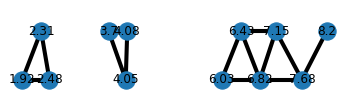

In [8]:
# Visualize sim graph
import networkx as nx

G = nx.Graph()
G.add_nodes_from(np.arange(n))
edges = np.stack(np.where(W > 0)).T
G.add_edges_from(edges)

# Adjust node position
y_pos = np.zeros(n)
y_pos[np.arange(1, n, step=2)] = 1#np.arange(n//2)+1
y_pos_map = dict(zip(np.argsort(data), y_pos))
permuted_y_pos = [y_pos_map[i] for i in range(n)]

# Set axis scale equal
plt.ylim(-0.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')

# Adjust edges width
weights = getSimilarity(data, weighted=True)

posdict = dict(zip(np.arange(n), tuple(zip(data, permuted_y_pos))))
labeldict = dict(zip(np.arange(n), np.around(data, 2)))
nx.draw(G, labels=labeldict, with_labels=True, width=(np.ones(edges.shape[0])+0.02)*4, pos=posdict)


In [9]:
W = getSimilarity(data, weighted=True)
W.shape

(12, 12)

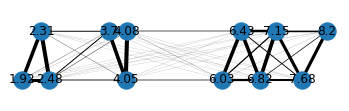

In [10]:
# Visualize sim graph
import networkx as nx

n = W.shape[0]

G = nx.Graph()
G.add_nodes_from(np.arange(n))
edges = np.stack(np.where(W > 0)).T

# Adjust edges width
weights = getSimilarity(data, weighted=True)

for i in range(n):
    for j in range(n):
        if W[i,j] > 0:
            G.add_edge(i, j, weight=(weights[i,j] + 0.02) * 4)
#G.add_edges_from(edges)


# Adjust node position
y_pos = np.zeros(n)
y_pos[np.arange(1, n, step=2)] = 1#np.arange(n//2)+1
y_pos_map = dict(zip(np.argsort(data), y_pos))
permuted_y_pos = [y_pos_map[i] for i in range(n)]

# Set axis scale equal
plt.ylim(-0.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')

posdict = dict(zip(np.arange(n), tuple(zip(data, permuted_y_pos))))
labeldict = dict(zip(np.arange(n), np.around(data, 2)))
weights_draw = nx.get_edge_attributes(G,'weight').values()
nx.draw(G, labels=labeldict, with_labels=True, pos=posdict, width=list(weights_draw))

#color_map = ['blue'] * N[0] + ['orange'] * N[1]


#nx.draw(G, with_labels=False, pos=posdict, node_color=color_map, width=list(weights_draw))

# Toy Example Dataset

In [11]:
n = 200

centers = [2,4,6,8]
sigma = 0.4
k = len(centers)


In [12]:
gt_label_indices = np.random.permutation(np.arange(n))

gt_labels = np.repeat(np.arange(k), n//k)[gt_label_indices]

In [13]:
cluster_data = np.stack([np.random.normal(loc=m, scale=sigma, size=n//k) for m in centers])

data = cluster_data.reshape(-1)[gt_label_indices]

data.shape

(200,)

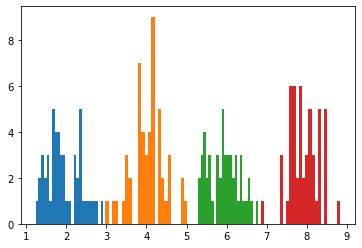

In [14]:
n_bins = n//2

for i in range(k): 
    plt.hist(cluster_data[i], bins=n_bins//k)

# Weighted Graph & Algorithm

In [15]:
W = getSimilarity(data, weighted=True)
W.shape

(200, 200)

In [16]:
L = getLaplacian(W)
L.shape

(200, 200)

In [17]:
lam, U = np.linalg.eigh(L)
sorted_ind = np.argsort(lam)

num_ref = k 
smallest_ind = sorted_ind[:k+num_ref]
lam[smallest_ind]

array([1.61145389e-15, 1.44110561e+00, 4.63013242e+00, 1.04994300e+01,
       2.29301620e+01, 2.77582679e+01, 3.10289209e+01, 3.19157452e+01])

In [18]:
U[:,smallest_ind[:k]]
U_best = U[:,smallest_ind[:k]]

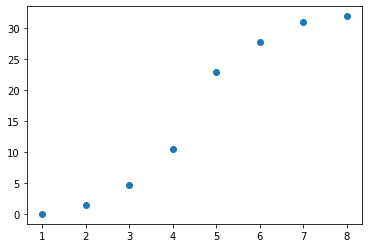

In [19]:
# Eigenvalue plot

plt.scatter(np.arange(k+num_ref)+1, lam[smallest_ind])

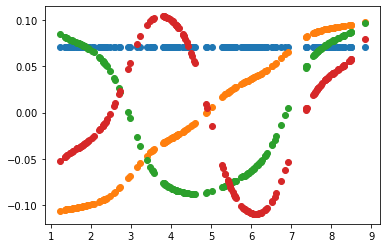

In [20]:
# Eigenvector plots

for i in range(k): 
    u = U_best[:,i]
    plt.scatter(data, u)

# Clustering Result

In [21]:
kmeans = KMeans(n_clusters=k).fit(U_best)
pred = kmeans.labels_

In [22]:
getLoss(data, pred)

38475.92066314853

In [23]:
getLoss(data, gt_labels)

38545.51305963143

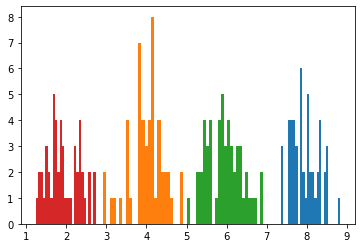

In [24]:
for c in np.unique(pred): 
    plt.hist(data[c==pred], bins=n_bins//k)

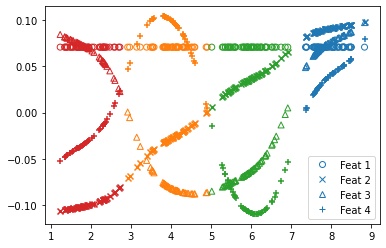

In [25]:
# Feature vector pattern of each cluster
clus_marker = plt.rcParams['axes.prop_cycle'].by_key()['color'][:4]
feat_marker = ['o', 'x', '^', '+']

for c in np.unique(pred): 
    """
    x = np.tile(data[c==pred], k)
    y = np.concatenate([U_best[c==pred,i] for i in range(k)])
    plt.scatter(x, y)
    """
    for i in range(k):
        if feat_marker[i] in ['o', '^']:
            plt.scatter(data[c==pred], U_best[c==pred,i], color=clus_marker[c], marker=feat_marker[i], facecolors='none')
        else:
            plt.scatter(data[c==pred], U_best[c==pred,i], color=clus_marker[c], marker=feat_marker[i])
            
plt.legend([])
import matplotlib.lines as mlines

legend_feat1 = mlines.Line2D([], [], marker='o', linestyle='None', markerfacecolor="none", label='Feat 1')
legend_feat2 = mlines.Line2D([], [], marker='x', linestyle='None', label='Feat 2')
legend_feat3 = mlines.Line2D([], [], marker='^', linestyle='None', markerfacecolor="none", label='Feat 3')
legend_feat4 = mlines.Line2D([], [], marker='+', linestyle='None', label='Feat 4')

plt.legend(handles=[legend_feat1, legend_feat2, legend_feat3, legend_feat4])

In [26]:
pred = spectral_clustering(data, k)

# Multi-local-scale Example

In [27]:

n = 500
R_range = [(0,1), (2,3), (4,5)]
k = len(R_range)

theta = np.random.uniform(0,2*np.pi,n)

intv_len = np.array([R_range[i][1]**2 - R_range[i][0]**2 for i in range(k)])
total_length = np.sum(intv_len)

cum_len = np.cumsum(intv_len)
true_Rs = []

cluster_size = [0] * k
cluster_indices = [[] for i in range(k)]

R_sq = np.random.uniform(0, total_length, n)
for i, r_sq in enumerate(R_sq):
    cluster = np.where(r_sq < cum_len)[0][0]
    
    r_min, r_max = R_range[cluster]
    intv_offset = r_sq - cum_len[cluster-1] if cluster != 0 else r_sq
    assert(intv_offset > 0)
    
    true_r_sq = r_min**2 + intv_offset
    assert(true_r_sq > 0)
    
    true_Rs.append(true_r_sq)
    cluster_size[cluster] += 1
    cluster_indices[cluster].append(i)
    
r = np.sqrt(np.array(true_Rs))

for i in range(k):
    cluster_indices[i] = np.array(cluster_indices[i])

In [28]:
gt_labels = np.zeros(n)
for c in range(k):
    i = cluster_indices[c]
    gt_labels[i] = c

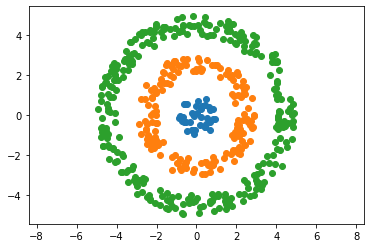

In [29]:
plt.axis('equal')

points = np.stack([r * np.cos(theta), r * np.sin(theta)])

for i in range(k):
    clus_points = points[:, cluster_indices[i]]
    plt.scatter(clus_points[0], clus_points[1])

In [30]:
cluster_size

[39, 167, 294]

# Test with Original Spectral Clustering

In [31]:
#points.shape
data = points.T
data.shape

(500, 2)

In [32]:
sigma=0.1
pred = spectral_clustering(data, k, sigma)

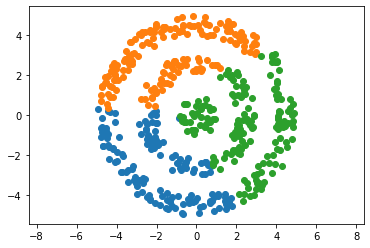

In [33]:
plt.axis('equal')

for c in range(k):
    cluster_indices = np.where(pred == c)
    clus_points = data[cluster_indices].T
    plt.scatter(clus_points[0], clus_points[1])

In [34]:
getLoss(data, pred)

248215.71663812324

In [35]:
getLoss(data, gt_labels)

590743.2765259724

# Local Scaling

Result of local scaling

In [36]:
pred = spectral_clustering(data, k, local_scaling=True)

(500,)


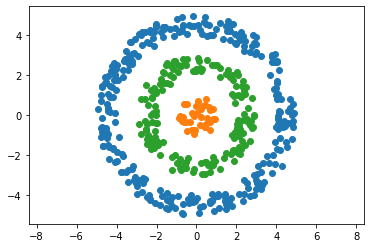

In [37]:
plt.axis('equal')
#clus_marker = [plt.rcParams['axes.prop_cycle'].by_key()['color'][i] for i in [1,0,2]]
clus_marker = plt.rcParams['axes.prop_cycle'].by_key()['color'][:3]

for c in range(k):
    cluster_indices = np.where(pred == c)
    clus_points = data[cluster_indices].T
    plt.scatter(clus_points[0], clus_points[1], color=clus_marker[c])

In [38]:
getLoss(data, pred)

590743.2765259724

Visualization of Sim Graph after local scaling

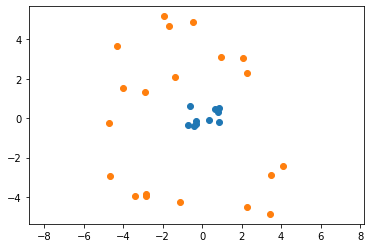

In [39]:
np.random.seed(2021)

all_points = []

N = [10, 20]
R_range = [(0,1), (2,6)]

k = len(R_range)

plt.axis('equal')

for i in range(k):
    r_min, r_max = R_range[i]
    n = N[i]
    r = np.sqrt(np.random.uniform(r_min**2, r_max**2, n))
    theta = np.random.uniform(0,2*np.pi,n)

    points = np.stack([r * np.cos(theta), r * np.sin(theta)])
    plt.scatter(points[0], points[1])
    
    all_points.append(points)
    
data = np.concatenate(all_points, axis=1).T

In [40]:
W = getSimilarity(data, weighted=False, hyperparam=5)
W.shape

(30, 30)

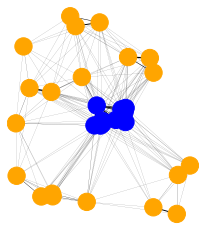

In [41]:
# Visualize sim graph
import networkx as nx

n = W.shape[0]

G = nx.Graph()
G.add_nodes_from(np.arange(n))
edges = np.stack(np.where(W > 0)).T

# Adjust edges width
weights = getSimilarity(data, weighted=True)

for i in range(n):
    for j in range(n):
        if W[i,j] > 0:
            G.add_edge(i, j, weight=(weights[i,j] + 0.02) * 4)
#G.add_edges_from(edges)

# Adjust node position

# Set axis scale equal
#plt.ylim(-0.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')


posdict = dict(zip(np.arange(n), tuple(zip(data[:,0], data[:,1]))))
labeldict = dict(zip(np.arange(n), np.around(data, 2)))

color_map = ['blue'] * N[0] + ['orange'] * N[1]
weights_draw = nx.get_edge_attributes(G,'weight').values()

nx.draw(G, with_labels=False, pos=posdict, node_color=color_map, width=list(weights_draw))

(30,)


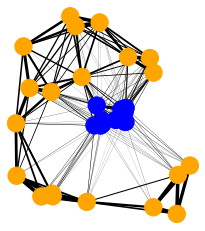

In [42]:
# Visualize sim graph
import networkx as nx

n = W.shape[0]

# Adjust edges width
weights = getSimilarity(data, weighted=True, local_scaling=True)

G = nx.Graph()
G.add_nodes_from(np.arange(n))
edges = np.stack(np.where(W > 0)).T
for i in range(n):
    for j in range(n):
        if W[i,j] > 0:
            G.add_edge(i, j, weight=(weights[i,j] + 0.02) * 4)
#G.add_edges_from(edges)

# Set axis scale equal
plt.gca().set_aspect('equal', adjustable='box')


posdict = dict(zip(np.arange(n), tuple(zip(data[:,0], data[:,1]))))
labeldict = dict(zip(np.arange(n), np.around(data, 2)))

color_map = ['blue'] * N[0] + ['orange'] * N[1]
weights_draw = nx.get_edge_attributes(G,'weight').values()
    
nx.draw(G, with_labels=False, pos=posdict, node_color=color_map, width=list(weights_draw))